#  RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

##  Step 1: Setup and Imports

In [2]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙ Step 2: Environment Setup

In [17]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "CartPole-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

trajectory_seed = 42
seed = 2025                  # Random seed to ensure experiment reproducibility
seed = 2024                  # Random seed to ensure experiment reproducibility
seed = 42

total_timesteps = 40_000   # Number of training steps for Expert PPO (Recommended: 30k for CartPole, 300k for Pendulum)

num_prefs = 1000            # Number of preference samples
sample_prefs = 200

# ===========================================================

set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 200
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'} | sample_length: {sample_length}")


✅ Environment: CartPole-v1 | Action space: Discrete | sample_length: 1000


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [18]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=trajectory_seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{trajectory_seed}.zip")
env.close()


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 6754     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.6        |
|    ep_rew_mean          | 24.6        |
| time/                   |             |
|    fps                  | 4068        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008349772 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_varia

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [19]:
def evaluate_policy(model, env, episodes=20):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
pi2_model.save(f"{env_id}_pi2_model_seed{trajectory_seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_16000_steps.zip with ~235.8 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [20]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset()

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.stack(rewards),       # [T]
        "mask": np.stack(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(model = pi2_model, env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")




🔄 Generating preference pairs: 100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


✅ Saved 1000 preference pairs to prefs_CartPole-v1_seed42.pkl


In [21]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## ⚙️ Step 7: Train DPO Policy

In [22]:
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


In [23]:

import torch
import torch.nn.functional as F

from stable_baselines3 import PPO
from copy import deepcopy

def train_dpo_from_ref(dataloader,ref_policy_sb3, env, beta= 0.05,  seed=42, epochs=100, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]


    ref_policy = ref_policy_sb3.policy  # frozen
    policy = deepcopy(ref_policy)  # trainable

    policy.to(device)
    ref_policy.to(device)
    ref_policy.eval()  # ensure frozen

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log probs from trainable policy ---

            dist1 = policy.get_distribution(obs1_flat)
            dist2 = policy.get_distribution(obs2_flat)

            logp1 = dist1.log_prob(acts1_flat)
            logp2 = dist2.log_prob(acts2_flat)



            #logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            #logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)

            # --- Compute log probs from reference policy (frozen) ---
            with torch.no_grad():
                dist1_ref = ref_policy.get_distribution(obs1_flat)
                dist2_ref = ref_policy.get_distribution(obs2_flat)

                logp1_ref = dist1_ref.log_prob(acts1_flat)
                logp2_ref = dist2_ref.log_prob(acts2_flat)

                #logp1_ref = torch.log_softmax(ref_policy(obs1_flat), dim=-1)
                #logp2_ref = torch.log_softmax(ref_policy(obs2_flat), dim=-1)


            lp1 = (logp1 - logp1_ref).view(B, -1)  # shape [B, T]
            lp2 = (logp2 - logp2_ref).view(B, -1)


            #lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            #lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits =beta*(logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy


In [24]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=None, beta = 1, epochs=100, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)
            lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = beta * (logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

#with open(f"prefs_{env_id}_seed{trajectory_seed}.pkl", "rb") as f:
#    prefs = pickle.load(f)
#prefs = prefs[:200]
#
#dataset = PreferenceDataset(prefs, is_discrete)
#loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
#
#dpo_model = train_dpo(loader, env)
#torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss: 0.6931
Epoch 34/100, Loss: 0.6931
Epoch 35/100, Loss: 0.6931
Epoch 36/100, Loss: 0.69

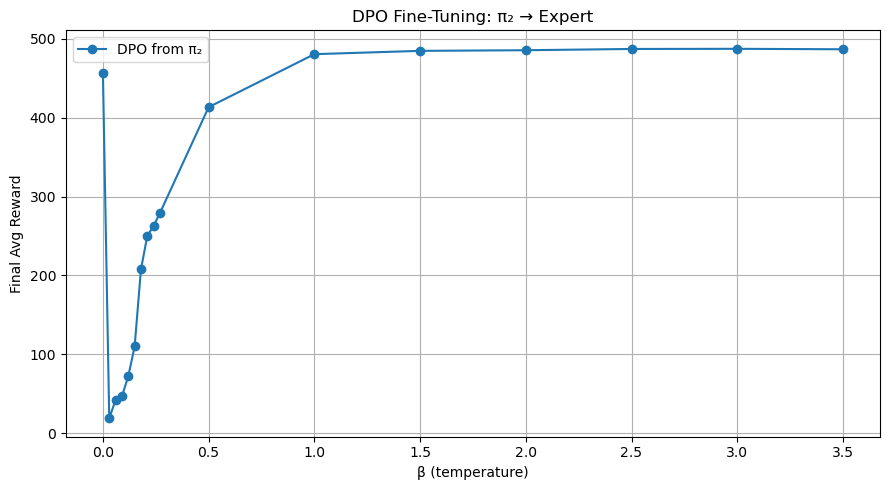

--------------------------------we use beta = {100: 3.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss: 0.6931
Epoch 34/100, Loss: 0

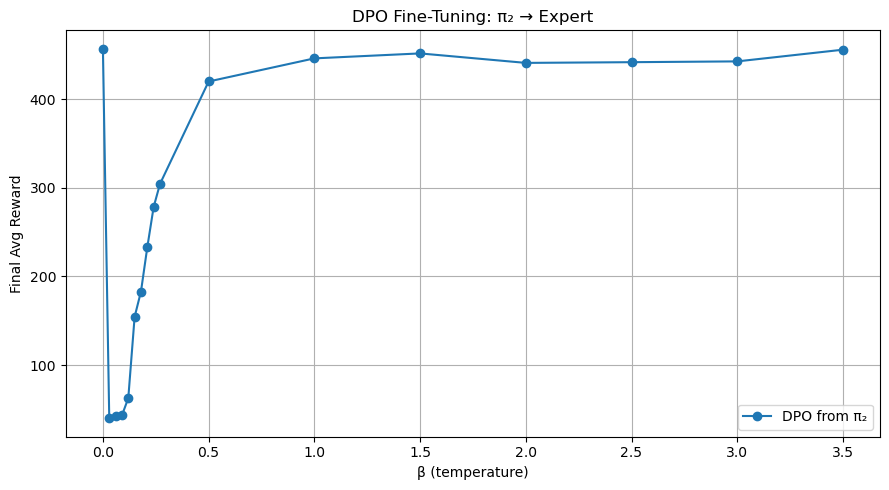

--------------------------------we use beta = {100: 3.0, 200: 0.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss: 0.6931
Epoch 34/10

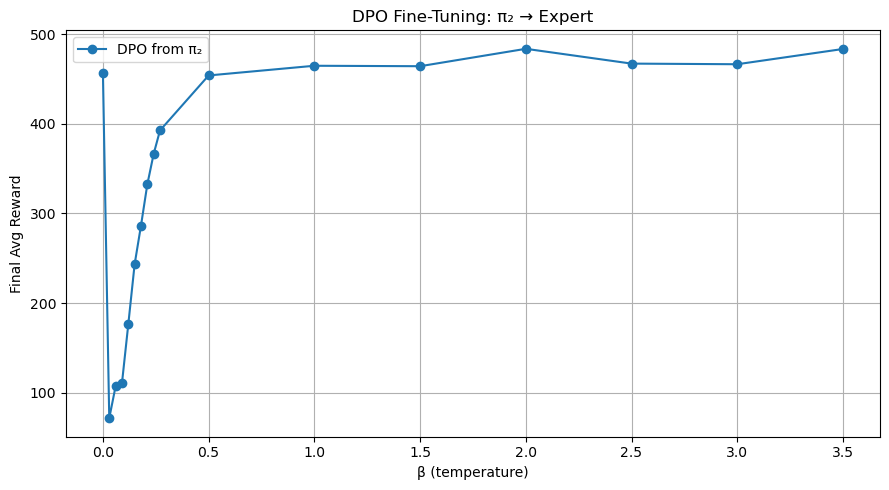

--------------------------------we use beta = {100: 3.0, 200: 0.0, 400: 2.0}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss: 0.6931
E

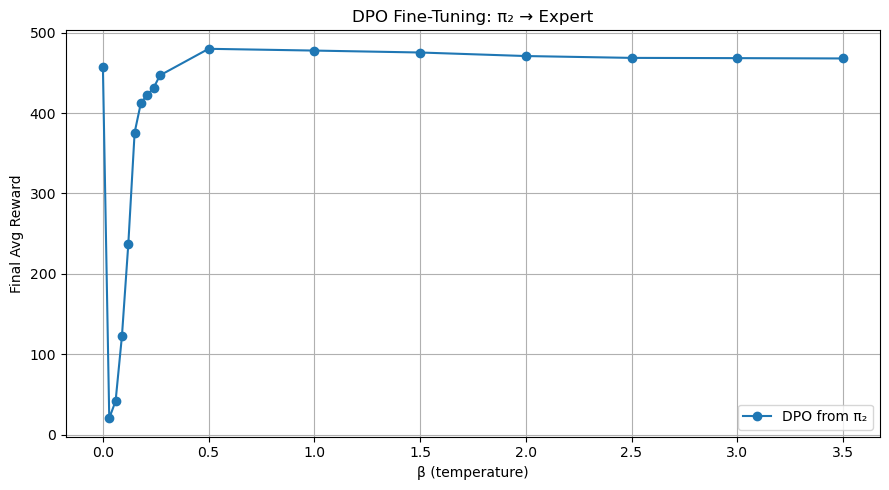

--------------------------------we use beta = {100: 3.0, 200: 0.0, 400: 2.0, 600: 0.5}
Training DPO (π₂ → Expert) with β = 0.0
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss

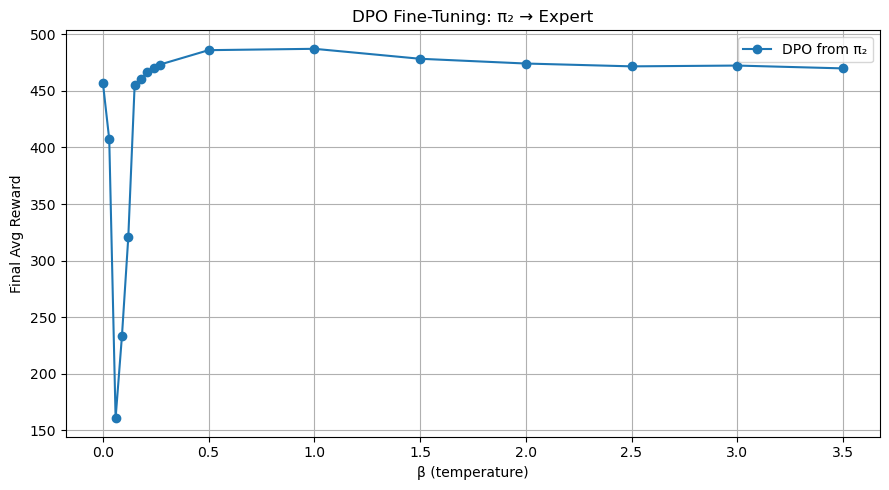

--------------------------------we use beta = {100: 3.0, 200: 0.0, 400: 2.0, 600: 0.5, 1000: 1.0}


In [25]:
import matplotlib.pyplot as plt

def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns



import matplotlib.pyplot as plt
import numpy as np

def fine_tune_dpo_with_betas(env, dataloader, pi2_model, beta_values_from_ref, epochs=100, device='cpu'):
    rewards_from_ref = {}

    obs_dim = env.observation_space.shape[0]
    is_discrete = hasattr(env.action_space, "n")
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # ✅ Train DPO starting from π₂ and moving toward expert
    for beta in beta_values_from_ref:
        print(f"Training DPO (π₂ → Expert) with β = {beta}")

        trained_policy_from_ref = train_dpo_from_ref(
            dataloader=dataloader,
            ref_policy_sb3=pi2_model,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy_from_ref, env, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards_from_ref[beta] = avg_reward


    # ✅ Plot both curves
    plt.figure(figsize=(9, 5))
    plt.plot(list(rewards_from_ref.keys()), list(rewards_from_ref.values()), marker='o', label="DPO from π₂")
    plt.xlabel("β (temperature)")
    plt.ylabel("Final Avg Reward")
    plt.title("DPO Fine-Tuning: π₂ → Expert")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards_from_ref


rewards = []
beta_from_ref = {}
for sample_pref in [100, 200, 400, 600, 1000]:
    with open(f"prefs_{env_id}_seed{trajectory_seed}.pkl", "rb") as f:
        prefs = pickle.load(f)
    prefs = prefs[:sample_pref]

    dataset = PreferenceDataset(prefs, is_discrete)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

    beta_values_from_ref = np.concatenate([np.arange(0, 0.3, 0.03), np.arange(0.5, 4, 0.5)])
    # we could also potentially choose an adaptive beta, like : beta = beta_init * (epoch / max_epochs)

    rewards_from_ref = fine_tune_dpo_with_betas(env, loader, pi2_model,beta_values_from_ref)
    rewards.append(rewards_from_ref)
    beta_from_ref[sample_pref] = max(rewards_from_ref, key = rewards_from_ref.get)
    #beta_from_ref = 0.5
    print(f"--------------------------------we use beta = {beta_from_ref}")


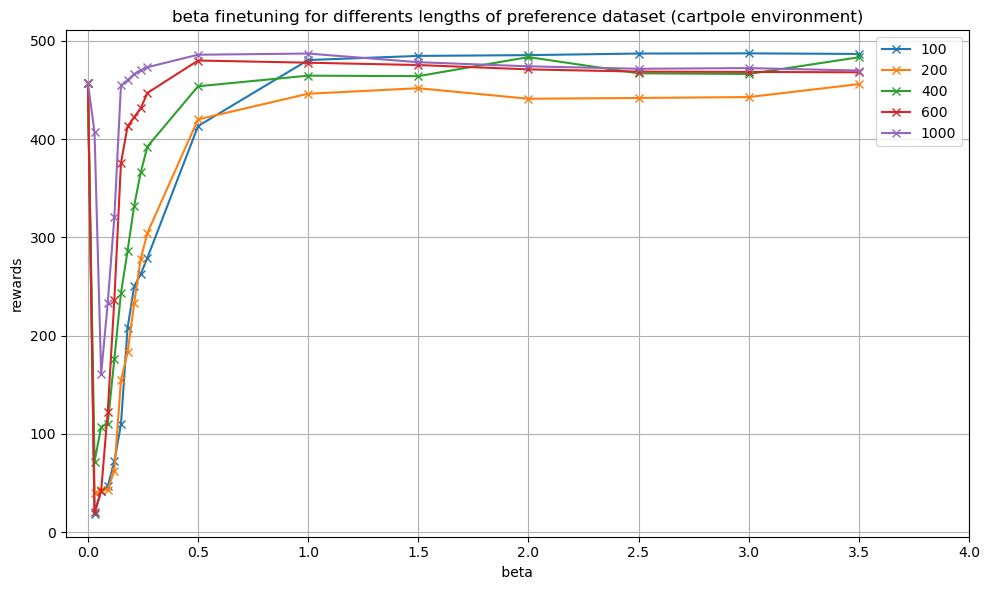

In [30]:
plt.figure(figsize=(10, 6))
sample_prefs = [100,200,400,600,1000]

# Loop through each dictionary and create a scatter plot
for i, reward_dict in enumerate(rewards):
    x = list(reward_dict.keys())
    y = list(reward_dict.values())
    plt.plot(x, y, label=f'{sample_prefs[i]}', marker='x')

# Configure the plot
plt.title("beta finetuning for differents lengths of preference dataset (cartpole environment)")
plt.xlabel(" beta ")
plt.xlim((-0.1,4))
plt.ylabel("rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()